In [1]:
import pandas as pd
from prophet import Prophet

from pandas_datareader import data as pdr
import yfinance as yfin

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import mlflow
import os 

yfin.pdr_override()

In [3]:
MLFLOW_IP = os.environ['MLFLOW_IP']
MLFLOW_PASSWORD = os.environ['MLFLOW_PASSWORD']
MLFLOW_USER = os.environ['MLFLOW_USER']
MLFLOW_PORT = os.environ['MLFLOW_PORT']

In [4]:
ticker_name = '^GSPC'

In [5]:
test_df = pdr.get_data_yahoo(ticker_name, start='2022-11-16', end='2023-01-04')

[*********************100%***********************]  1 of 1 completed


In [6]:
ticker = pdr.get_data_yahoo(ticker_name, start='2021-08-01', end='2022-11-15')

[*********************100%***********************]  1 of 1 completed


In [7]:
ticker

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-02 00:00:00-04:00,4406.859863,4422.180176,4384.810059,4387.160156,4387.160156,3724090000
2021-08-03 00:00:00-04:00,4392.740234,4423.790039,4373.000000,4423.149902,4423.149902,3965190000
2021-08-04 00:00:00-04:00,4415.950195,4416.169922,4400.229980,4402.660156,4402.660156,4260760000
2021-08-05 00:00:00-04:00,4408.859863,4429.759766,4408.859863,4429.100098,4429.100098,3769410000
2021-08-06 00:00:00-04:00,4429.069824,4440.819824,4429.069824,4436.520020,4436.520020,3451870000
...,...,...,...,...,...,...
2022-11-08 00:00:00-05:00,3817.020020,3859.399902,3786.280029,3828.110107,3828.110107,4607640000
2022-11-09 00:00:00-05:00,3810.939941,3818.199951,3744.219971,3748.570068,3748.570068,4645010000
2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,3956.370117,5781260000


In [8]:
df = ticker[['Close']].copy()

In [9]:
df.reset_index(inplace=True)

In [10]:
df.rename({'Date': 'ds', 'Close': 'y'}, axis=1, inplace=True)

In [11]:
df

,ds,y
0,2021-08-02 00:00:00-04:00,4387.160156
1,2021-08-03 00:00:00-04:00,4423.149902
2,2021-08-04 00:00:00-04:00,4402.660156
3,2021-08-05 00:00:00-04:00,4429.100098
4,2021-08-06 00:00:00-04:00,4436.520020
...,...,...
321,2022-11-08 00:00:00-05:00,3828.110107
322,2022-11-09 00:00:00-05:00,3748.570068
323,2022-11-10 00:00:00-05:00,3956.370117
324,2022-11-11 00:00:00-05:00,3992.929932


In [12]:
df['ds'] = df['ds'].dt.tz_localize(None)

In [13]:
mlflow.set_tracking_uri('http://{}:{}'.format(MLFLOW_IP, MLFLOW_PORT))

In [14]:
exp_id = mlflow.create_experiment(
    name='Prophet',
    artifact_location="sftp://{}:{}@{}:/home/godder/mlflow_storage/artifacts".format(MLFLOW_USER, MLFLOW_PASSWORD, MLFLOW_IP),
    tags={'ticker':'^GSPC'}
)

RestException: RESOURCE_ALREADY_EXISTS: Experiment 'Prophet' already exists.

In [15]:
exp_id = mlflow.get_experiment_by_name('Prophet').experiment_id

mlflow.set_experiment(experiment_id=exp_id)
print('done')

done


In [16]:
mlflow.start_run(experiment_id=exp_id, run_name='Prophet training')

<ActiveRun: >

In [17]:
mlflow.set_tag('ticker', '^GSPC')

In [18]:
mlflow.log_param('changepoint_range', 1)
mlflow.log_param('changepoint_prior_scale', 0.25)
mlflow.log_param('weekly_seasonality', False)

m = Prophet(changepoint_range=1, changepoint_prior_scale=0.25, weekly_seasonality=False)
m.fit(df)

08:41:57 - cmdstanpy - INFO - Chain [1] start processing
08:41:57 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
days=45

In [20]:
future = m.make_future_dataframe(periods=days)
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

In [21]:
forecast = m.predict(future)

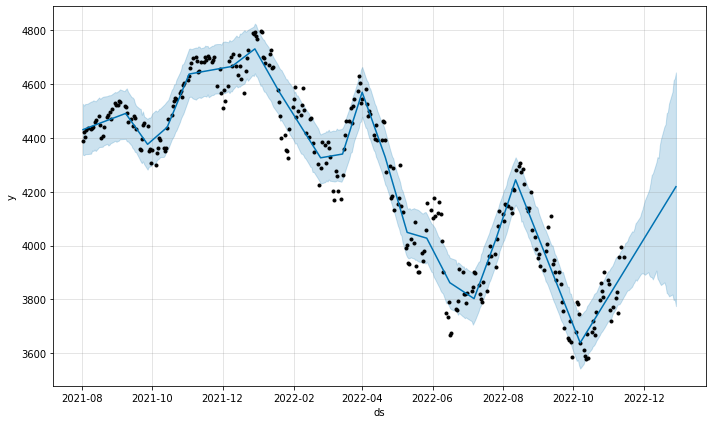

In [22]:
fig1 = m.plot(forecast)

In [23]:
fig1.axes[0].plot(test_df.index, test_df[['Close']].values, color='g')

In [24]:
mlflow.log_figure(fig1, 'test_plot.png')

/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


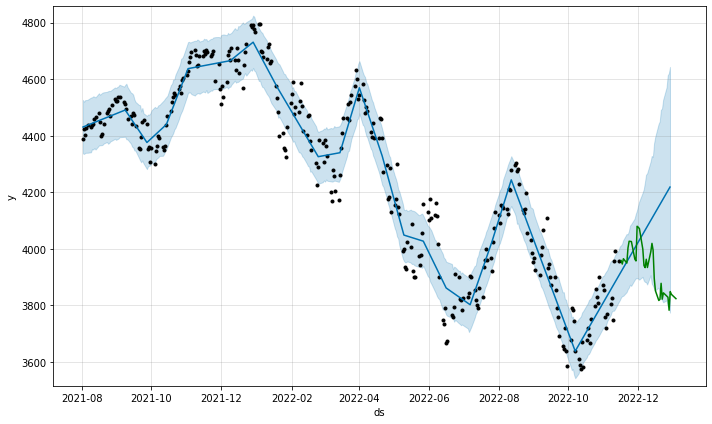

In [25]:
fig1

In [26]:
print('MSE', mean_squared_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat']))
print('MAPE', mean_absolute_percentage_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat']))
print('MAE', mean_absolute_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat']))

MSE 45123.32545938866
MAPE 0.042239958478016884
MAE 163.48678081205296


In [27]:
mae_test = mean_absolute_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat'])
mape_test = mean_absolute_percentage_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat'])
mse_test = mean_squared_error(test_df['Close'], forecast[forecast['ds'] >= '2022-11-16']['yhat'])

mlflow.log_metric('MAE/test', mae_test)
mlflow.log_metric('MAPE/test', mape_test)
mlflow.log_metric('MSE/test', mse_test)

In [28]:
signature = mlflow.models.signature.infer_signature(future)

/home/godder/.local/lib/python3.8/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [29]:
mlflow.prophet.log_model(m,
                         'prophet',
                         registered_model_name='Prophet',
                         signature=signature,
                         input_example=future)

Registered model 'Prophet' already exists. Creating a new version of this model...
2023/01/18 08:42:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Prophet, version 3
Created version '3' of model 'Prophet'.


In [30]:
mlflow.end_run()

# Fetching and testing

In [31]:
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/Prophet/1"
)

/home/godder/.local/lib/python3.8/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [32]:
preds = model.predict(future)

done checking... changing stage to "Staging"

In [33]:
tracking_uri = mlflow.get_tracking_uri()
registry_uri = mlflow.get_registry_uri()

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)

client.transition_model_version_stage(
    name="Prophet",
    version=3,
    stage="Staging"
)

client.transition_model_version_stage(
    name="Prophet",
    version=1,
    stage="Archived"
)
print('done')

done
